# Predicting Stock Prices with LSTM (5 features)

### Importing Relevent Libraries

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

### Loading processed_TSLA.csv data


In [2]:
# Load the TSLA data file

data_tsla = pd.read_csv('../data/processed_TSLA.csv')

file_path = '../data/processed_TSLA.csv'

data_tsla.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,Sentiment
0,0,2010-06-29,3.800,5.000,3.508,4.778,4.778,93831500,1
1,1,2010-06-30,5.158,6.084,4.660,4.766,4.766,85935500,0
2,2,2010-07-01,5.000,5.184,4.054,4.392,4.392,41094000,0
3,3,2010-07-02,4.600,4.620,3.742,3.840,3.840,25699000,1
4,4,2010-07-06,4.000,4.000,3.166,3.222,3.222,34334500,-1


### Cofiguration and parameters

In [3]:
config = {
    "data": {
        "window_size": 100,
        "train_split_size": 0.95,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 5, #Using 5 features without Sentiment Column
        "num_lstm_layers": 3, 
        "lstm_size": 150,
        "dropout": 0.6,
    },
    "training": {
        "device": "cpu",
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.001,
        "scheduler_step_size": 10,
    }
}

### A function to load TSLA data and Ploting the Stock Close values

In [ ]:
def load_tsla_data(file_path, plot=False):
    # Read the TSLA data from the CSV file
    data = pd.read_csv(file_path)

    data_date = data['Date'].tolist()
    data_close_price = data['Close'].tolist()
    data_close_price = np.array(data_close_price)
    
    data_features = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
    data_features = np.array(data_features)

    num_data_points = len(data_date)
    display_date_range = "from " + data_date[0] + " to " + data_date[num_data_points-1]
    print("Number data points:", num_data_points, display_date_range)

    if plot:
        fig = figure(figsize=(25, 5), dpi=80)
        fig.patch.set_facecolor((1.0, 1.0, 1.0))
        plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
        xticks = [data_date[i] if ((i % config["plots"]["xticks_interval"] == 0 and (num_data_points - i) > config["plots"]["xticks_interval"]) or i == num_data_points - 1) else None for i in range(num_data_points)] # make x ticks nice
        x = np.arange(0, len(xticks))
        plt.xticks(x, xticks, rotation='vertical')
        plt.title("Daily adjusted close price for TSLA, " + display_date_range)
        plt.grid(visible=True, which='major', axis='y', linestyle='--')
        plt.show()

    return data_date, data_close_price, data_features, num_data_points, display_date_range

Number data points: 2956 from 2010-06-29 to 2022-03-24


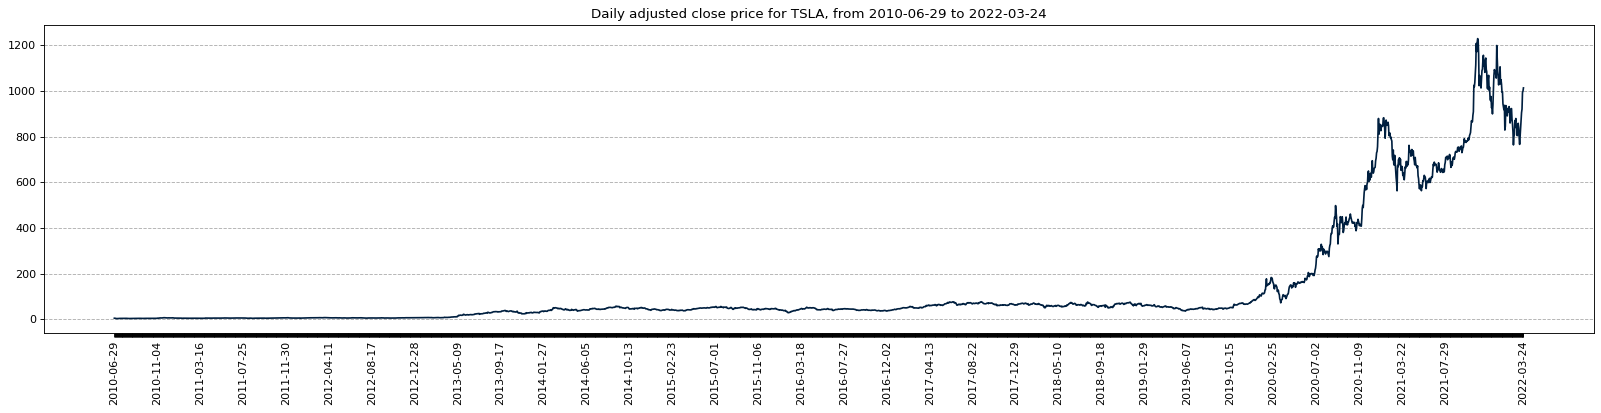

In [5]:
data_date, data_close_price, data_features, num_data_points, display_date_range = load_tsla_data(file_path, plot=config["plots"]["show_plots"])

### Data preparation: normalizing raw financial data

In [6]:
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu) / self.sd
        return normalized_x

    def inverse_transform(self, x, feature_idx=None):
        if feature_idx is not None:
            # Apply inverse transform for a specific feature
            return (x * self.sd[0, feature_idx]) + self.mu[0, feature_idx]
        
        if x.ndim == 1 and self.sd.shape[1] == 1:
            # If x is 1D and there's only one feature in the standard deviation
            return (x * self.sd[0, 0]) + self.mu[0, 0]
        
        if x.ndim == 1:
            # If x is 1D but multiple features exist, raise an informative error
            raise ValueError("Mismatch: input x is 1D, but multiple features exist in the normalizer. Specify feature_idx.")
        
        return (x * self.sd) + self.mu


# normalize
scaler = Normalizer()
normalized_data_close_price = scaler.fit_transform(data_close_price)
normalized_data_features = scaler.fit_transform(data_features)

### Data preparation: generating training and validation datasets

In [7]:
def prepare_data_x(x, window_size):
    # Perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size, x.shape[1]), strides=(x.strides[0], x.strides[0], x.strides[1]))
    return output[:-1], output[-10]

def prepare_data_y(x, window_size):
    # Use the next day as label
    output = x[window_size:]
    return output

def prepare_data(normalized_data_close_price, normalized_data_features, config, plot=False):
    # Prepare input features (X)
    data_x, data_x_unseen = prepare_data_x(normalized_data_features, window_size=config["data"]["window_size"])
    
    # Prepare target values (y)
    data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])

    # Split dataset
    split_index = int(data_y.shape[0] * config["data"]["train_split_size"])
    data_x_train = data_x[:split_index]
    data_x_val = data_x[split_index:]
    data_y_train = data_y[:split_index]
    data_y_val = data_y[split_index:]
    
    print(data_x_train.shape)
    print(data_y_train.shape)

    return split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen


# normalized_data_close_price prepared from 'Close' prices

split_index, data_x_train, data_y_train, data_x_val, data_y_val, data_x_unseen = prepare_data(
    normalized_data_close_price, 
    normalized_data_features, 
    config
)

(2713, 100, 5)
(2713,)


In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        #x = np.expand_dims(x, 2) 
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

Train data shape (2713, 100, 5) (2713,)
Validation data shape (143, 100, 5) (143,)


## Defining the LSTM model

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

## Model training

In [10]:
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# create `DataLoader`
train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

# define optimizer, scheduler and loss function
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

# Early stopping parameters
early_stopping_patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0

# begin training
for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
          .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))
    
    # Check for early stopping
    if loss_val < best_val_loss:
        best_val_loss = loss_val
        patience_counter = 0  # Reset counter if validation loss improves
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

Epoch[1/100] | loss train:0.062746, test:0.084783 | lr:0.001000
Epoch[2/100] | loss train:0.027699, test:0.061803 | lr:0.001000
Epoch[3/100] | loss train:0.017800, test:0.028643 | lr:0.001000
Epoch[4/100] | loss train:0.018486, test:0.038944 | lr:0.001000
Epoch[5/100] | loss train:0.014121, test:0.038868 | lr:0.001000
Epoch[6/100] | loss train:0.014347, test:0.042895 | lr:0.001000
Epoch[7/100] | loss train:0.013966, test:0.019381 | lr:0.001000
Epoch[8/100] | loss train:0.016672, test:0.022471 | lr:0.001000
Epoch[9/100] | loss train:0.015561, test:0.055458 | lr:0.001000
Epoch[10/100] | loss train:0.012343, test:0.041492 | lr:0.001000
Epoch[11/100] | loss train:0.009732, test:0.026087 | lr:0.000100
Epoch[12/100] | loss train:0.008534, test:0.019894 | lr:0.000100
Epoch[13/100] | loss train:0.009199, test:0.027394 | lr:0.000100
Epoch[14/100] | loss train:0.007823, test:0.019836 | lr:0.000100
Epoch[15/100] | loss train:0.006958, test:0.016932 | lr:0.000100
Epoch[16/100] | loss train:0.00658

## Model evaluation

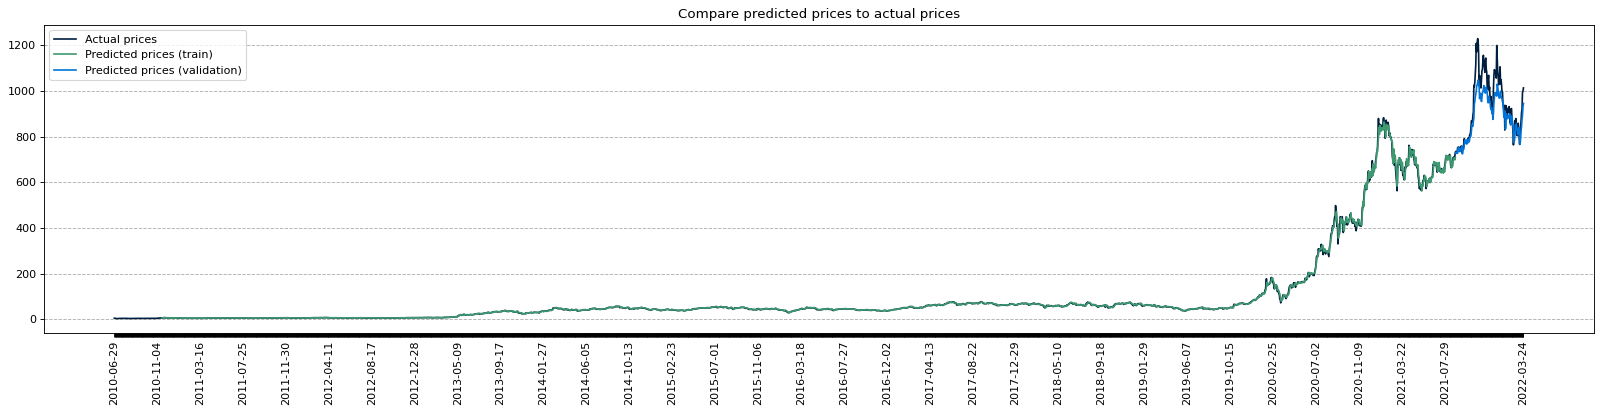

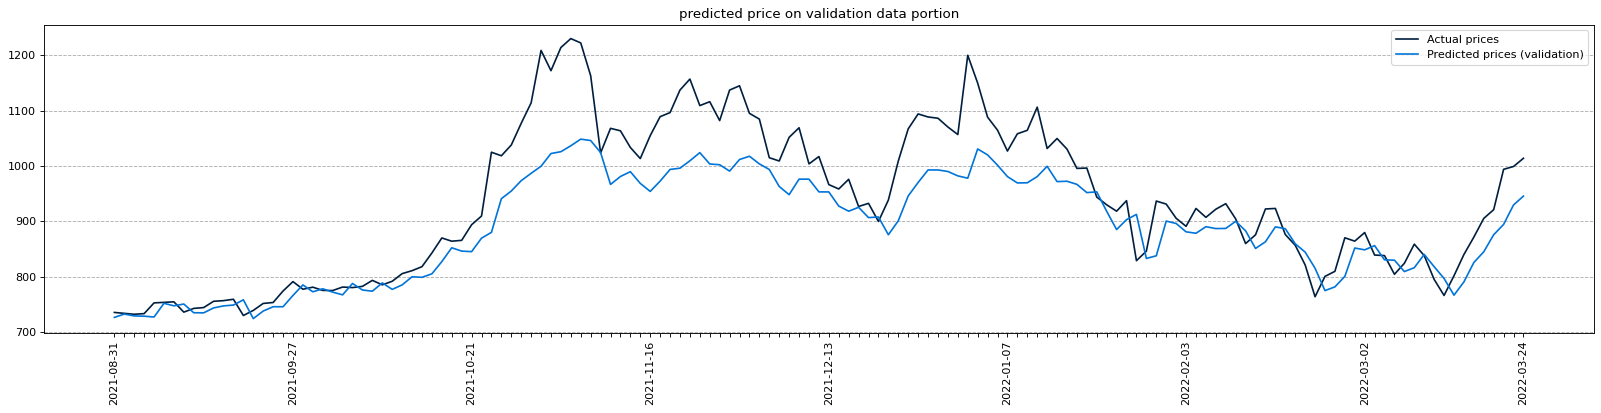

In [11]:
#re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()

# predict on the training data, to see how well the model managed to learn and memorize

predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

if config["plots"]["show_plots"]:

    # prepare data for plotting, show predicted prices

    to_plot_data_y_train_pred = np.zeros(num_data_points)
    to_plot_data_y_val_pred = np.zeros(num_data_points)

    # Only inverse transform the 'Close' feature (index 3)
    to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train, feature_idx=3)
    to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val, feature_idx=3)



    to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
    to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
    plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("Compare predicted prices to actual prices")
    xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
    x = np.arange(0,len(xticks))
    plt.xticks(x, xticks, rotation='vertical')
    plt.grid(visible=True, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

    # prepare data for plotting, zoom in validation
    to_plot_data_y_val_subset = scaler.inverse_transform(data_y_val, feature_idx=3)
    to_plot_predicted_val = scaler.inverse_transform(predicted_val, feature_idx=3)
    to_plot_data_date = data_date[split_index + config["data"]["window_size"]:]


    # plots

    fig = figure(figsize=(25, 5), dpi=80)
    fig.patch.set_facecolor((1.0, 1.0, 1.0))
    plt.plot(to_plot_data_date, to_plot_data_y_val_subset, label="Actual prices", color=config["plots"]["color_actual"])
    plt.plot(to_plot_data_date, to_plot_predicted_val, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
    plt.title("predicted price on validation data portion")
    xticks = [to_plot_data_date[i] if ((i%int(config["plots"]["xticks_interval"]/5)==0 and (len(to_plot_data_date)-i) > config["plots"]["xticks_interval"]/6) or i==len(to_plot_data_date)-1) else None for i in range(len(to_plot_data_date))] # make x ticks nice
    xs = np.arange(0,len(xticks))
    plt.xticks(xs, xticks, rotation='vertical')
    plt.grid(visible=True, which='major', axis='y', linestyle='--')
    plt.legend()
    plt.show()

# Prepare the data to be saved
processed_data = pd.DataFrame({
    'Date': data_date,
    'Actual_Close': data_close_price
})

# Add the predicted values to the DataFrame
processed_data['Predicted_Close'] = np.nan
processed_data.loc[config["data"]["window_size"]:split_index+config["data"]["window_size"]-1, 'Predicted_Close'] = scaler.inverse_transform(predicted_train, feature_idx=3).flatten()
processed_data.loc[split_index+config["data"]["window_size"]:num_data_points, 'Predicted_Close'] = scaler.inverse_transform(predicted_val, feature_idx=3).flatten()


# Read the original processed_TSLA.csv
original_data = pd.read_csv('../data/processed_TSLA.csv')

# Merge the original data with the predicted data based on the Date column
merged_data = pd.merge(original_data, processed_data[['Date', 'Predicted_Close']], on='Date', how='left')

# Save to CSV
merged_data.to_csv('../data/Processed_predicted_TSLA.csv', index=False)